In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U accelerate
!pip install -q -U transformers
!pip install -q -U scipy

Rodando em: CPU (Lenta)
Iniciando Análise para: 2noise/ChatTTS
 Baixando commits...
 Baixando releases...

MÉTRICAS:
 - Merge Ratio: 1.75%
 - Intervalo Releases: 64.2 dias

 Gerando gráficos...


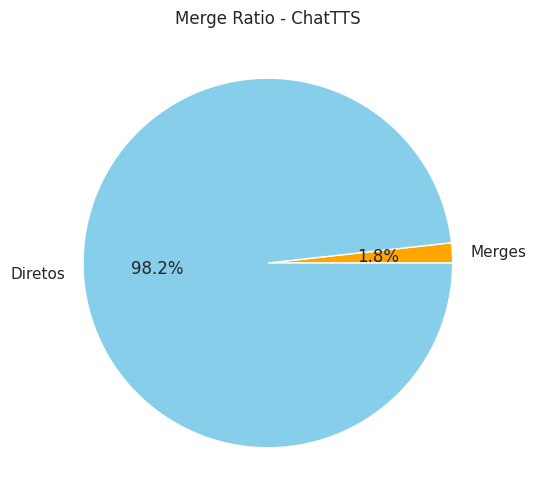

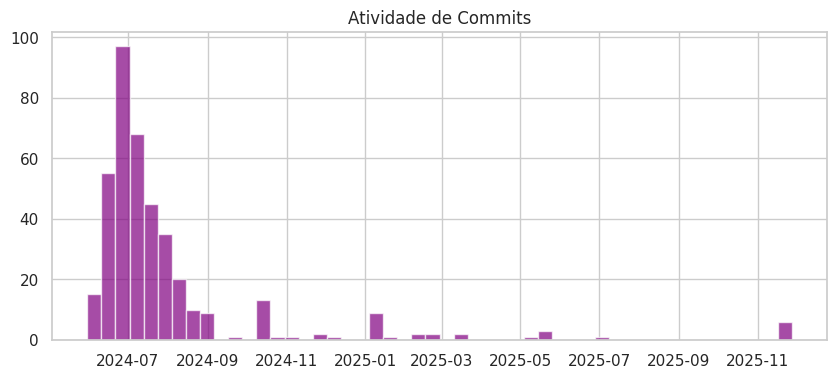


 Iniciando inferência


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



 Tabela Comparativa:
|    | Modelo          | Fluxo                                                                                        | Estratégia     |
|---:|:----------------|:---------------------------------------------------------------------------------------------|:---------------|
|  0 | BART-Large-MNLI | Gitflow                                                                                      | Rapid Releases |
|  1 | Flan-T5-Base    | Ver Texto                                                                                    | LTS            |
|  2 | DistilGPT2      | ... a lot smoother.                                                                          | Inconclusivo   |
|    |                 |                                                                                              |                |
|    |                 |                                                                                              |                |
|    |             

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import requests
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, set_seed
from datetime import datetime
import os
import json
import sys
from google.colab import files
import shutil

REPO_OWNER = "2noise"
REPO_NAME = "ChatTTS"
GITHUB_TOKEN = ""

OUTPUT_DIR = "resultados_chattts_atividade2"
os.makedirs(OUTPUT_DIR, exist_ok=True)

LABELS_FLOW = ["Gitflow", "GitHub Flow", "Trunk Based Development"]
LABELS_RELEASE = ["Rapid Releases", "Release Train", "LTS (Long Term Support)"]

DEVICE = 0 if torch.cuda.is_available() else -1
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU (Lenta)"
print(f"Rodando em: {device_name}")
set_seed(42)

print(f"Iniciando Análise para: {REPO_OWNER}/{REPO_NAME}")


def get_headers():
    return {"Authorization": f"token {GITHUB_TOKEN}"} if GITHUB_TOKEN else {}

def fetch_github_data(endpoint, limit=432):
    print(f" Baixando {endpoint}...")
    data = []
    page = 1
    while len(data) < limit:
        url = f"https://api.github.com/repos/{REPO_OWNER}/{REPO_NAME}/{endpoint}?per_page=100&page={page}"
        try:
            r = requests.get(url, headers=get_headers())
            if r.status_code != 200:
                print(f" Parou na página {page} (Status {r.status_code})")
                break
            batch = r.json()
            if not batch: break
            data.extend(batch)
            page += 1
        except Exception as e:
            print(f"❌ Erro: {e}")
            break
    return data

commits_data = fetch_github_data("commits", limit=400)
releases_data = fetch_github_data("releases", limit=100)

if not commits_data:
    print("Erro crítico: Nenhum dado baixado. Verifique Token ou Repo.")
else:
    df_commits = pd.DataFrame([{
        "date": pd.to_datetime(c["commit"]["author"]["date"]),
        "message": c["commit"]["message"],
        "is_merge": c["commit"]["message"].lower().startswith(("merge pull request", "merge branch"))
    } for c in commits_data])

    df_releases = pd.DataFrame([{
        "tag": r["tag_name"],
        "date": pd.to_datetime(r["published_at"])
    } for r in releases_data if r["published_at"]])

    df_commits = df_commits.sort_values("date")
    if not df_releases.empty:
        df_releases = df_releases.sort_values("date")
        avg_release_days = df_releases["date"].diff().dt.days.mean()
    else:
        avg_release_days = 0

    merge_ratio = (df_commits["is_merge"].sum() / len(df_commits)) * 100
    days_active = (df_commits["date"].max() - df_commits["date"].min()).days
    commits_per_day = len(df_commits) / (days_active if days_active > 0 else 1)

    print(f"\nMÉTRICAS:\n - Merge Ratio: {merge_ratio:.2f}%\n - Intervalo Releases: {avg_release_days:.1f} dias")


    print("\n Gerando gráficos...")
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(6, 6))
    plt.pie([merge_ratio, 100-merge_ratio], labels=["Merges", "Diretos"], autopct='%1.1f%%', colors=['orange','skyblue'])
    plt.title(f"Merge Ratio - {REPO_NAME}")
    plt.savefig(f"{OUTPUT_DIR}/grafico_merge.png")
    plt.show()
    plt.figure(figsize=(10, 4))
    df_commits["date"].hist(bins=50, color="purple", alpha=0.7)
    plt.title("Atividade de Commits")
    plt.savefig(f"{OUTPUT_DIR}/grafico_timeline.png")
    plt.show()


    context_text = (
        f"Project {REPO_NAME} Metrics: Merge Ratio {merge_ratio:.1f}%, Release Interval {avg_release_days:.1f} days. "
        f"Commit velocity {commits_per_day:.1f}/day. "
        f"Software theory: High merges (>20%) implies Gitflow/Feature Branch. Low (<5%) implies Trunk-Based. "
        f"Frequent releases (<14 days) implies Rapid Releases."
    )

    results = []

    print("\n Iniciando inferência")

    try:
        classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=DEVICE)
        res_flow = classifier(context_text, LABELS_FLOW)
        res_rel = classifier(context_text, LABELS_RELEASE)
        results.append({
            "Modelo": "BART-Large-MNLI",
            "Tarefa": "Classificação",
            "Fluxo": res_flow['labels'][0],
            "Estratégia": res_rel['labels'][0],
            "Confiança": f"{res_flow['scores'][0]*100:.0f}%"
        })
    except Exception as e: print(f"Erro BART: {e}")

    try:
        t5 = pipeline("text2text-generation", model="google/flan-t5-base", device=DEVICE)
        prompt = f"Analyze metrics: Merge Ratio {merge_ratio:.1f}%, Release Interval {avg_release_days:.1f} days. Is it Gitflow or Trunk-Based? Is it Rapid Release or LTS?"
        res_t5 = t5(prompt, max_length=100, truncation=True)[0]['generated_text']
        results.append({
            "Modelo": "Flan-T5-Base",
            "Tarefa": "Instrução",
            "Fluxo": "Ver Texto",
            "Estratégia": res_t5,
            "Confiança": "N/A"
        })
    except Exception as e: print(f"Erro T5: {e}")

    try:
        gpt = pipeline("text-generation", model="distilgpt2", device=DEVICE)
        prompt_gpt = f"Based on {merge_ratio:.1f}% merge ratio, the development flow is"
        res_gpt = gpt(prompt_gpt, max_length=40, truncation=True, num_return_sequences=1)[0]['generated_text']
        results.append({
            "Modelo": "DistilGPT2",
            "Tarefa": "Geração",
            "Fluxo": res_gpt.replace(prompt_gpt, " ..."),
            "Estratégia": "Inconclusivo",
            "Confiança": "N/A"
        })
    except Exception as e: print(f"Erro GPT: {e}")

    pd.DataFrame(results).to_csv(f"{OUTPUT_DIR}/tabela_comparativa.csv", index=False)
    with open(f"{OUTPUT_DIR}/metadados.json", "w") as f:
        json.dump({"metrics": {"merges": merge_ratio, "releases": avg_release_days}}, f)

    print("\n Tabela Comparativa:")
    print(pd.DataFrame(results)[["Modelo", "Fluxo", "Estratégia"]].to_markdown())

    shutil.make_archive("analise_chattts", 'zip', OUTPUT_DIR)
    print("\n⬇ Baixando resultados")
    files.download("analise_chattts.zip")